<a href="https://colab.research.google.com/github/viktor-krasikov/uii_public/blob/master/%D0%A1%D0%BF%D1%80%D0%B8%D0%BD%D1%82_RAG_9_10_%D0%B8%D1%8E%D0%BB%D1%8F_%D0%94%D0%B5%D0%BD%D1%8C_1_%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%BD%D1%8B%D0%B9_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#СПРИНТ 9 июля. КЛАСТЕРИЗАЦИЯ

# **Библиотеки, импорты, функции**

### Подготовка. Установка библиотек, подключение к OpenAI...

In [ ]:
# @title Установка библиотек 1
# Патч для proxies
!pip install -q --upgrade --upgrade-strategy eager "regex" "charset-normalizer<4" "idna" "urllib3<3" "certifi" "requests" "anyio<4" "distro<2" "sniffio" "h11<0.15" "httpcore==1.*" "annotated-types" "typing-extensions<5" "pydantic-core==2.27.1" "pydantic<3" "jiter<1" "tqdm" "colorama" "openai" "tiktoken" "httpx<0.28"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.1/755.1 kB 11.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
google-colab 1.0.0 requires requests==2.32.3, but you have requests 2.32.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.3.1 which is incompatible.
google-genai 1.23.0 requires anyio<5.0.0,>=4.8.0, but you have anyio 3.7.1 which is incompatible.
google-genai 1.23.0 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.27.2 which is incompatible.
firebase-admin 6.9.0 requires httpx[http2]==0.28.1, but you have httpx 0.27.2 which is incompatible.


In [ ]:
# @title Установка библиотек 2
# 1) Ставим всё для LangChain
!pip install -q langchain langchain-community langchain-core langchain-openai langchain-text-splitters langsmith openai faiss-cpu
# 2) Чиним зависимости сети и асинхронных запросов
!pip install requests==2.32.3 httpx==0.28.1 anyio==4.8.0
# 3) Переустанавливаем NumPy и SciPy с pandas
!pip install -U numpy pandas scipy --force-reinstall

  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached anyio-4.8.0-py3-none-any.whl.metadata (4.6 kB)
Using cached requests-2.32.3-py3-none-any.whl (64 kB)
Using cached httpx-0.28.1-py3-none-any.whl (73 kB)
Using cached anyio-4.8.0-py3-none-any.whl (96 kB)
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
  Attempting uninstall: anyio
    Found existing installation: anyio 3.7.1
    Uninstalling anyio-3.7.1:
      Successfully uninstalled anyio-3.7.1
  Attempting uninstall: httpx
    Found existing installation: httpx 0.27.2
    Uninstalling httpx-0.27.2:
      Successfully uninstalled httpx-0.27.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.

In [ ]:
!pip install --upgrade scikit-learn

### Импорты и функции

In [ ]:
# @title Импорты

import os
import re
import copy
import json
import pickle
import shutil
import zipfile
import requests
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

from google.colab import userdata

from langchain.text_splitter import (
    CharacterTextSplitter,
    NLTKTextSplitter,
    RecursiveCharacterTextSplitter,
)
from langchain.docstore.document import Document
from langchain.document_loaders import TextLoader
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS

import openai
from openai import OpenAI, AsyncOpenAI

import tiktoken

# Игнорируем ворнинги для чистого вывода
warnings.filterwarnings("ignore")

print("✅ Импорты успешно загружены!")
print("🔢 NumPy:", np.__version__)
print("📊 pandas:", pd.__version__)

✅ Импорты успешно загружены!
🔢 NumPy: 2.3.1
📊 pandas: 2.3.1


In [ ]:
# Ключ OPENAI
# openai.api_key = userdata.get("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

# Загружаем моделей для эмбединга
model_embed_large = "text-embedding-3-large"
embeddings_large = OpenAIEmbeddings(model=model_embed_large)

model_embed = "text-embedding-ada-002"  # ["text-embedding-3-small", "text-embedding-3-large", "text-embedding-ada-002"]
embeddings = OpenAIEmbeddings(model=model_embed)

In [ ]:
# @title Функция для загрузки данных из Яндекс.Диска в рабочий каталог root_path
def download_and_extract_yandex_disk(url, output_dir):
    """
    Скачивает архив с Яндекс.Диска и распаковывает содержимое корневой папки в указанный каталог.

    :param url: Ссылка на файл или папку на Яндекс.Диске (публичная).
    :param output_dir: Папка, куда будет распаковано содержимое архива.
    """
    os.makedirs(output_dir, exist_ok=True)
    zip_file_path = os.path.join(output_dir, 'data.zip')

    # Преобразование ссылки для прямого скачивания
    direct_url = f"https://cloud-api.yandex.net/v1/disk/public/resources/download?public_key={url}"
    response = requests.get(direct_url)
    if response.status_code != 200:
        print(f"Ошибка при запросе ссылки: {response.status_code}")
        return False

    download_link = response.json().get('href')
    if not download_link:
        print("Не удалось получить ссылку для скачивания.")
        return False

    # Скачиваем файл
    with requests.get(download_link, stream=True) as file_response:
        with open(zip_file_path, 'wb') as file:
            shutil.copyfileobj(file_response.raw, file)
    print(f"Файл успешно загружен: {zip_file_path}")

    # Распаковываем содержимое архива
    if zipfile.is_zipfile(zip_file_path):
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            for member in zip_ref.namelist():
                # Извлекаем только файлы без корневой папки
                member_path = os.path.relpath(member, start=os.path.commonpath(zip_ref.namelist()))
                target_path = os.path.join(output_dir, member_path)
                if not member.endswith('/'):  # Пропускаем директории
                    os.makedirs(os.path.dirname(target_path), exist_ok=True)
                    with open(target_path, 'wb') as f:
                        f.write(zip_ref.read(member))
        print(f"Файлы успешно распакованы в папку: {output_dir}")
        os.remove(zip_file_path)  # Удаляем архив после распаковки
        return True
    else:
        print("Скачанный файл не является ZIP-архивом.")
        return False

In [ ]:
# @title Служебные функции и переменные ноутбука

# Подсчет токенов в строке
# Подсчет токенов в строке
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    encoding = tiktoken.get_encoding(encoding_name)
    return len(encoding.encode(string))

# Функция для расчета стоимости запросов
def calculate_cost(completion_questions, usd_price, verbose=False):
    """
    Функция для расчета стоимости входных и выходных токенов,
    а также общей стоимости запроса. Значения сразу округляются до 4 знаков.
    """
    input_price = pricing_per_million_tokens_usd.get(completion_questions.model)["input_price"]
    output_price = pricing_per_million_tokens_usd.get(completion_questions.model)["output_price"]

    prompt_tokens_cost = ((int(completion_questions.usage.prompt_tokens) * input_price) / 1_000_000) * usd_price
    completion_tokens_cost = ((int(completion_questions.usage.completion_tokens) * output_price) / 1_000_000) * usd_price
    total_cost = prompt_tokens_cost + completion_tokens_cost

    cost_details = {
        "prompt_tokens_cost": round(prompt_tokens_cost, 4),
        "completion_tokens_cost": round(completion_tokens_cost, 4),
        "total_cost": round(total_cost, 4)
    }

    if verbose:
        print(f"Цена {completion_questions.usage.prompt_tokens} входных токенов, руб: {cost_details['prompt_tokens_cost']}")
        print(f"Цена {completion_questions.usage.completion_tokens} выходных токенов, руб: {cost_details['completion_tokens_cost']}")
        print(f"Общая цена запроса, руб: {cost_details['total_cost']}")

    return cost_details

def calculate_total_cost(data):
    # Инициализируем переменную для общей стоимости
    total_cost = 0

    # Проходим по каждому элементу списка и извлекаем значение 'total_cost'
    for item in data:
        for key, value in item.items():
            total_cost += value['total_cost']

    # Печатаем общую стоимость
    return f"Общая стоимость вызовов для запроса: {total_cost:.2f} руб"

def load_unique_questions(file_path):
    # Чтение файла xlsx
    df = pd.read_excel(file_path)
    # Извлечение списка вопросов
    unique_questions = df['Вопрос'].tolist()
    return unique_questions

# Установка цен для расчета стоимости запросов
usd_price = 110
encoding_name = "cl100k_base"
model_parsed = 'gpt-4o-mini-2024-07-18'
# Define pricing embed for each model in USD per 1M tokens
pricing_per_million_tokens_usd = {
    "gpt-4o-mini": {"input_price": 0.15, "output_price": 0.6},
    "gpt-4o-mini-2024-07-18": {"input_price": 0.15, "output_price": 0.6},
    "gpt-4o": {"input_price": 2.5, "output_price": 10},
    # "gpt-4o-2024-08-06": {"input_price": 2.5, "output_price": 10},
    # "gpt-4o-2024-05-13": {"input_price": 10, "output_price": 15},
    "text-embedding-3-small": 0.020,
    "text-embedding-3-large": 0.130,
    "text-embedding-ada-002": 0.100
    }

history_cost = []

# Корневая папка занятия
root_path = '/content/drive/MyDrive/Занятия УИИ/Исследование БД. Кластеризация/'

# Пути и другие переменные ноутбука
db_index_path = "/faiss_index/"
text_file = 'base_uii_edit_22.txt'

# Модель GPT
model_answer = 'gpt-4o-mini'

len_chunk = 1024


# Производим загрузку данных для чекпоинтов с Яндекс.Диска
files_url = "https://disk.yandex.ru/d/94pepH9co6ZijQ"
local_path = '/content/local_data'

if download_and_extract_yandex_disk(files_url, local_path):
    # Переназначаем корневую папку занятия на папку загрузки с Яндекс.Диска
    root_path = local_path + '/'
    print(f'Корневая папка изменена на: {root_path}')

def show_questions(questions_list, n=500):
    """
    Выводит количество вопросов и показывает первые n вопросов из списка.
    """
    print("\033[1;34m📄 Загруженные вопросы из базы\033[0m")
    print(f"\033[1;91m✅ Всего вопросов: {len(questions_list)}\033[0m")

    print(f"\n📌 Показываю первые {min(n, len(questions_list))} вопросов:\n")
    for i, question in enumerate(questions_list[:n], start=1):
        print(f"{i}. {question}")

def load_unique_questions(file_path):
    """
    Загружает вопросы из XLSX-файла и выводит статус загрузки.
    Возвращает список уникальных вопросов.
    """
    print(f"🔗 Читаем файл: {file_path} ...")

    # Чтение файла xlsx
    df = pd.read_excel(file_path)
    # Извлечение списка вопросов
    unique_questions = df['Вопрос'].tolist()

    print(f"\n✅ Файл с базой вопросов успешно загружен!")
    print(f"\nВсего загружено вопросов: {len(unique_questions)}")

    return unique_questions

Файл успешно загружен: /content/local_data/data.zip
Файлы успешно распакованы в папку: /content/local_data
Корневая папка изменена на: /content/local_data/


In [ ]:
# @title Загружаем функции и модели для эмбединга
model_embed_large = "text-embedding-3-large"
embeddings_large = OpenAIEmbeddings(model=model_embed_large)

model_embed = "text-embedding-ada-002"  # ["text-embedding-3-small", "text-embedding-3-large", "text-embedding-ada-002"]
embeddings = OpenAIEmbeddings(model=model_embed)

def embed_questions(questions, embeddings_model, path_prefix):
    """
    Генерирует эмбеддинги для списка вопросов
    и сохраняет их вместе со списком вопросов.
    """
    print(f"📡 Генерируем эмбеддинги для {len(questions)} вопросов...")
    vectors = embeddings_model.embed_documents(questions)
    vectors = np.array(vectors)
    print(f"\n✅ Готово! Размер массива: {vectors.shape}")

    # Сохраняем список вопросов
    with open(root_path + 'unique_questions.json', 'w', encoding='utf-8') as f:
        json.dump(questions, f, ensure_ascii=False, indent=2)
    print(f"\nСписок вопросов сохранён: unique_questions.json")

    # Сохраняем эмбеддинги
    np.save(root_path + 'vectors.npy', vectors)
    print(f"\nЭмбеддинги сохранены: vectors.npy")

    return vectors



In [ ]:
# @title Загружаем функции для кластеризации
def elbow_method(vectors, cluster_range):
    distortions = []
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(vectors)
        distortions.append(kmeans.inertia_)
    return distortions

def find_optimal_k_elbow(vectors, max_k=1500, num_points=30, random_state=42):
    i_values = np.logspace(np.log10(1), np.log10(max_k), num=num_points, dtype=int)
    i_values = np.unique(i_values)  # Remove duplicates
    distortions = []
    for i in i_values:
        if i <= len(vectors):
            kmean = KMeans(n_clusters=i, random_state=random_state)
            kmean.fit(vectors)
            distortions.append(kmean.inertia_)

    distortions = np.array(distortions)
    # Log-transform for regression
    log_i_values = np.log10(i_values).reshape(-1, 1)
    split_point = int(len(i_values) * 2 / 3)
    reg_model = LinearRegression()
    reg_model.fit(log_i_values[:split_point], distortions[:split_point])
    reg_line = reg_model.predict(log_i_values)
    # Plot
    plt.figure(figsize=(12, 8))
    plt.plot(i_values, distortions, 'bx-', label="KMeans Inertia")
    plt.plot(i_values, reg_line, 'r--', label="Regression line (2/3 points)")
    plt.xscale('log')
    plt.xlabel("Number of clusters (log scale)", fontsize=12)
    plt.ylabel("Inertia", fontsize=12)
    plt.title("KMeans Elbow Method", fontsize=14)
    plt.xticks(i_values, labels=i_values, rotation=45)
    plt.legend()
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    plt.show()
    print(f"✅ Elbow method completed! Points tested: {len(i_values)}")

    return i_values, distortions, reg_line

# кластеризация
def run_kmeans_clustering(vectors, n_clusters):
    """
    Выполняет KMeans и возвращает:
    - метки кластеров
    - центроиды
    - обученную модель KMeans (по желанию)
    """
    from sklearn.cluster import KMeans

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
    clusters = kmeans.fit_predict(vectors)
    centroids = kmeans.cluster_centers_
    print(f"✅ KMeans: {n_clusters} кластеров построено.")
    return clusters, centroids, kmeans


# Сщхранение кластеров и центроидов
def save_clusters_and_centroids(questions, clusters, centroids, path_prefix):
    import numpy as np
    import pandas as pd
    np.save("Центроиды сохранены: centroids.npy")
    df_clusters = pd.DataFrame({
        'Вопрос': questions,
        'Кластер': clusters
    })
    df_clusters.to_csv(path_prefix + 'clusters.csv', index=False, encoding="utf-8")
    print(f" Таблица кластеров сохранена: clusters.csv ({len(df_clusters)} строк)")
    return df_clusters

# запустить t-SNE
def run_tsne_projection(vectors, clusters, questions):
    """
    Делает t-SNE и возвращает tsne_df и centroids_df для визуализации
    """
    from sklearn.manifold import TSNE
    import pandas as pd

    tsne = TSNE(n_components=2, random_state=42, learning_rate='auto', init='random')
    tsne_results = tsne.fit_transform(vectors)

    tsne_df = pd.DataFrame({
        'TSNE1': tsne_results[:, 0],
        'TSNE2': tsne_results[:, 1],
        'Cluster': clusters,
        'Message': questions
    })

    centroids_df = tsne_df.groupby('Cluster')[['TSNE1', 'TSNE2']].mean().reset_index()
    centroids_df['text'] = centroids_df.apply(
        lambda row: f"Кластер: {row['Cluster']}\n({row['TSNE1']:.2f}, {row['TSNE2']:.2f})",
        axis=1
    )
    print(f"✅ t-SNE готов!")
    return tsne_df, centroids_df

#Красивый вывод
def show_tsne_preview(tsne_df, df_clusters, num_rows=5):
    print(f"✅ t-SNE чекпоинт: всего точек — {len(tsne_df)}")
    print(f"📌 Всего кластеров в t-SNE: {tsne_df['Cluster'].nunique()}")
    # Примеры точек t-SNE
    print("\n🔍 Примеры точек t-SNE:")
    display(tsne_df[['TSNE1', 'TSNE2', 'Cluster', 'Message']].head(num_rows))
    # Топ-5 кластеров по размеру
    sizes = tsne_df.groupby('Cluster').size().reset_index(name='Count')
    sizes_sorted = sizes.sort_values('Count', ascending=False).head(num_rows)
    print("\n📊 Топ-5 самых больших кластеров:")
    display(sizes_sorted)

# Функция t-SNE визуализация кластеров с центроидами и контурами
def plot_tsne_clusters(tsne_df, centroids_df, title='t-SNE визуализация кластеров'):
    import plotly.express as px
    import plotly.graph_objects as go
    from scipy.spatial import ConvexHull
    import numpy as np

    fig = px.scatter(
        tsne_df,
        x='TSNE1',
        y='TSNE2',
        color='Cluster',
        hover_data={'Cluster': True, 'TSNE1': False, 'TSNE2': False, 'Message': True},
        title=title
    )

    for cluster_id in tsne_df['Cluster'].unique():
        cluster_points = tsne_df[tsne_df['Cluster'] == cluster_id][['TSNE1', 'TSNE2']].values
        if len(cluster_points) >= 3:
            hull = ConvexHull(cluster_points)
            hull_points = cluster_points[hull.vertices]
            hull_points = np.append(hull_points, [hull_points[0]], axis=0)

            fig.add_trace(go.Scatter(
                x=hull_points[:, 0],
                y=hull_points[:, 1],
                mode='lines',
                line=dict(color='rgba(0,0,0,0.5)', width=1),
                fill='toself',
                fillcolor='rgba(0,0,0,0.1)',
                name=f'Область кластера {cluster_id}',
                visible='legendonly'
            ))

    fig.add_scatter(
        x=centroids_df['TSNE1'],
        y=centroids_df['TSNE2'],
        mode='markers',
        marker=dict(color='red', size=10, symbol='x'),
        name='Centroids',
        text=centroids_df['text'],
        hoverinfo='text'
    )

    fig.update_layout(
        height=800,
        coloraxis_colorbar=dict(x=0.95)
    )

    fig.show()

def elbow_method_range(vectors, cluster_range=None, max_clusters=None, show_vline=None):
    """
    Метод локтя для KMeans:
    - Если cluster_range задан — используем его.
    - Если max_clusters задан — создаём range(1, max_clusters + 1).
    - Если show_vline указан — добавляем вертикальную линию.
    """
    if cluster_range is None:
        if max_clusters is None:
            raise ValueError("Нужно задать cluster_range или max_clusters")
        cluster_range = range(1, max_clusters + 1)

    distortions = []
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(vectors)
        distortions.append(kmeans.inertia_)

    # Один единый график
    plt.figure(figsize=(12, 8))
    plt.plot(cluster_range, distortions, marker='o', markersize=3)

    if show_vline:
        plt.axvline(x=show_vline, color='gray', linestyle='--', label=f'k = {show_vline}')
        plt.legend()

    plt.title('Метод локтя')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Инерция')
    plt.grid()
    plt.show()

    return distortions

In [ ]:
# @title  вывод примеров вопросов по кластерам c генерирацией заголовка кластера через GPT
def generate_cluster_title(cluster_questions, model_name="gpt-4o-mini-2024-07-18"):

    messages = [
        {
            "role": "system",
            "content": (
                "Ты — методолог Университета Искусственного Интеллекта (УИИ). "
                "Твоя задача: прочитать список вопросов кластера и придумать краткое и ёмкое уникальное название для этого кластера "
                "(2-5 слов), отражающее основную тему вопросов данного кластера"
                "Не добавляй лишних комментариев."
            )
        },
        {
            "role": "user",
            "content": (
                f"Вопросы кластера:\n\n{cluster_questions}\n\n"
                "Сформулируй название кластера:"
            )
        }
    ]

    # Вызов OpenAI
    client = openai.OpenAI()
    response = client.chat.completions.create(
        model=model_name,
        messages=messages,
        temperature=0.3,
    )

    title = response.choices[0].message.content.strip()
    return title

def generate_all_cluster_titles(unique_questions, clusters, n_clusters, model_name="gpt-4o-mini-2024-07-18"):
    cluster_titles = {}
    for cluster_id in range(n_clusters):
        questions = [q for idx, q in enumerate(unique_questions) if clusters[idx] == cluster_id]
        if not questions:
            continue  # Пропускаем пустые кластеры
        cluster_questions_str = "\n".join(questions)
        cluster_title = generate_cluster_title(cluster_questions_str, model_name=model_name)
        cluster_titles[cluster_id] = cluster_title
        print(f"✅ Кластер {cluster_id}: {cluster_title}")
    return cluster_titles

# вывод примеров вопросов по кластерам.
def show_clustered_questions_with_titles(
    unique_questions,
    clusters,
    n_clusters,
    cluster_titles=None,
    selected_clusters=None,
    random_sample=False,
    max_questions=None
):
    """
    Красиво выводит вопросы по выбранным кластерам с названиями.
    Если selected_clusters не указан — выводятся все.
    """
    from collections import defaultdict

    # Группируем вопросы по кластерам
    clustered_questions = defaultdict(list)
    for idx, label in enumerate(clusters):
        clustered_questions[label].append(unique_questions[idx])

    # Определяем кластеры для вывода
    cluster_ids = selected_clusters if selected_clusters else clustered_questions.keys()

    print(f"✅ Всего кластеров: {n_clusters}")
    print(f"📌 Выведем кластеры: {list(cluster_ids)}\n")

    # Выводим каждый выбранный кластер
    for cluster_id in cluster_ids:
        questions = clustered_questions[cluster_id]

        cluster_title = cluster_titles.get(cluster_id, "Без названия") if cluster_titles else "Без названия"

        print(f"🔹 Кластер ID: {cluster_id} | Название: {cluster_title} | Всего вопросов: {len(questions)}\n")

        # Если max_questions не указан — показываем все
        questions_to_show = questions[:max_questions] if max_questions else questions

        for i, question in enumerate(questions_to_show, start=1):
            print(f"   {i}. {question}")

        if max_questions and len(questions) > max_questions:
            print(f"   ... и ещё {len(questions) - max_questions} вопросов")

        print("-" * 50)

In [ ]:
# @title Очистка дублей TF-IDF
def clean_clusters_tfidf_only(unique_questions, clusters, tfidf_threshold=0.7):
    """
    Удаляет дубликаты вопросов по TF-IDF cosine similarity.
    Возвращает:
      - df_clusters: исходный DataFrame с колонкой 'Кластер'
      - unique_questions_df: очищенный DataFrame без дублей
    """
    import pandas as pd
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity
    from IPython.display import Markdown, display

    # 1️⃣ Формируем DataFrame с кластерами
    df_clusters = pd.DataFrame({
        'Вопрос': unique_questions,
        'Кластер': clusters
    })

    # 2️⃣ TF-IDF вектора
    vectorizer = TfidfVectorizer().fit_transform(df_clusters['Вопрос'])
    tfidf_vectors = vectorizer.toarray()
    cosine_sim = cosine_similarity(tfidf_vectors)

    # 3️⃣ Находим дубликаты
    duplicates = set()
    for i in range(len(cosine_sim)):
        for j in range(i + 1, len(cosine_sim)):
            if cosine_sim[i][j] > tfidf_threshold:
                duplicates.add(j)

    # 4️⃣ Удаляем дубликаты
    unique_questions_df = df_clusters.drop(df_clusters.index[list(duplicates)]).reset_index(drop=True)

    summary_md = f"""
### ✅ Всего вопросов до очистки: **{len(df_clusters)}**
### Найдено и удалено дубликатов: **{len(duplicates)}**
### Уникальных вопросов после TF-IDF: **{len(unique_questions_df)}**
"""
    display(Markdown(summary_md))

    return df_clusters, unique_questions_df

In [ ]:
# @title Подготовка документа, нарезка на чанки, загрузка базы с вопросами

# Функция для векторизации текста
def text_to_vector(text, embeddings):
    return embeddings.embed_documents([text])[0]

# Извлечение последнего номера списка
def extract_last_list_number(md_text):
    matches = re.findall(r"^(\d+)\.", md_text, re.MULTILINE)
    return int(matches[-1]) if matches else None

# Проверка позиции последнего элемента (заголовок или список)
def last_element(md_text):
    headers = [m.start() for m in re.finditer(r"(#{1,6}) .+", md_text)]
    lists = [m.start() for m in re.finditer(r"^(\d+)\.", md_text, re.MULTILINE)]
    return None if not headers and not lists else bool(headers and (not lists or headers[-1] > lists[-1]))

# Извлечение заголовков из текста
def extract_headers(md_text, prev_headers):
    matches = re.findall(r"(#{1,6}) (.+)", md_text)
    if not matches:
        last_number = extract_last_list_number(md_text)
        return prev_headers, None if last_element(md_text) else last_number

    max_level = len(matches[-1][0])
    headers = {k: v for k, v in prev_headers.items() if k < max_level}
    for match in matches:
        level = len(match[0])
        headers[level] = match[1]

    last_number = extract_last_list_number(md_text)
    return headers, None if last_element(md_text) else last_number

# Основная обработка текста
def process_text_file(file_path, len_chunk):
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=len_chunk, chunk_overlap=128)
    source_chunks = []
    prev_headers, item_number = {}, ""

    try:
        loader = TextLoader(file_path, encoding='utf8')
        documents = loader.load()
        for chunk_id, chunk in enumerate(tqdm(text_splitter.split_text(documents[0].page_content))):
            new_headers, last_numerik = extract_headers(chunk, prev_headers)
            prev_headers = copy.deepcopy(new_headers)

            add_hierarchy = " ".join(
                [f'{"#" * level} {header}' for level, header in sorted(prev_headers.items())]
            ) + item_number

            new_chunk = f"{chunk}\nИерархия фрагмента текста в документе: {add_hierarchy}"
            item_number = f" пункт {last_numerik}." if last_numerik is not None else ""

            source_chunks.append(Document(page_content=new_chunk, metadata={'chunk_id': chunk_id}))
    except Exception as e:
        print(f"Ошибка обработки файла {file_path}: {e}")
    print("Обработка завершена!")
    return source_chunks

# Красиво показывает чанки
def show_chunks_preview(source_chunks, start=0, end=5):
    """
    Показывает пример чанков + считает общий размер по символам и токенам.
    """
    print(f"\n✅ Всего чанков: {len(source_chunks)}\n")

    for idx, chunk in enumerate(source_chunks[start:end], start=start):
        text = chunk.page_content
        length = len(text)
        print(f"🔹 Чанк #{idx} | {length:,} символов")
        print("-" * 60)
        print(text[:500])  # Только начало для удобства
        print("-" * 60)
        print("\n")

    # Итог: считаем по ВСЕМ чанкам
    full_text = " ".join([x.page_content for x in source_chunks])
    total_tokens = num_tokens_from_string(full_text, "cl100k_base")
    total_chars = len(full_text)

    print(f"Общий объём текста: ~{total_chars:,} символов")
    print(f"Общий объём для embeddings: ~{total_tokens:,} токенов")

In [ ]:
# @title Создание FAISS базы и оценка стоимости
def create_faiss_index(source_chunks, embeddings, root_path, db_index_path, text_file, len_chunk,
                       model_embed, pricing_per_million_tokens_usd, usd_price, max_tokens_per_batch=250_000):
    """
    Создаёт FAISS индекс и считает стоимость embeddings с учётом лимита ~300k токенов за запрос.
    Если чанков много — разбивает на батчи и добавляет по частям.
    """
    if not len(source_chunks):
        print("Нет чанков для индексации.")
        return None, 0
    print(f"✅ Всего чанков: {len(source_chunks)}")

    batched_chunks = []
    current_batch = []
    current_tokens = 0

    for chunk in source_chunks:
        chunk_tokens = num_tokens_from_string(chunk.page_content, "cl100k_base")
        if current_tokens + chunk_tokens > max_tokens_per_batch:
            batched_chunks.append(current_batch)
            current_batch = []
            current_tokens = 0
        current_batch.append(chunk)
        current_tokens += chunk_tokens
    if current_batch:
        batched_chunks.append(current_batch)
    # Создаём первый батч
    db_faiss_main = FAISS.from_documents(batched_chunks[0], embeddings)

    # Остальные батчи добавляем по частям
    for batch in batched_chunks[1:]:
        db_faiss_main.add_documents(batch)

    # Итоговая статистика
    full_text = ' '.join([x.page_content for x in source_chunks])
    count_tokens = num_tokens_from_string(full_text, "cl100k_base")
    print(f"✅ Всего токенов (все чанки): {count_tokens:,}")

    # Сохраняем локально
    index_name = f"{os.path.splitext(text_file)[0]}_{len_chunk}_large"
    save_path = os.path.join(root_path, db_index_path, index_name)
    db_faiss_main.save_local(save_path)
    print(f"Индекс FAISS сохранён: {save_path}")

    # Расчёт стоимости
    embed_price = pricing_per_million_tokens_usd.get(model_embed, 0)
    total_cost = (count_tokens * embed_price / 1_000_000) * usd_price
    print(f"\nОриентировочная цена за embeddings: {total_cost:.2f} руб.")

    return db_faiss_main, count_tokens

In [ ]:
# @title Группировка списка вопросов по кластерам и получение релевантных чанков к каждому вопросу

def build_clusters_context(db_faiss_main, unique_questions_df, k=10, cluster_titles=None):
    """
    Для каждого кластера подбирает k релевантных чанков.
    Возвращает clusters_context.
    Если есть словарь cluster_titles — выводит название кластера.
    """
    clusters_context = {}
    grouped_df = unique_questions_df.groupby('Кластер')

    for cluster, group in grouped_df:
        cluster_context = []
        questions = group['Вопрос'].tolist()

        # Получаем заголовок, если передан словарь
        cluster_title = cluster_titles.get(cluster) if cluster_titles else None

        print(f"\033[1;34mКластер {cluster}\033[0m")
        if cluster_title:
            print(f"\033[1;32mНазвание кластера:\033[0m {cluster_title}")
        print("\033[1;30m" + "-" * 50 + "\033[0m")

        for question in questions:
            sim_docs = db_faiss_main.similarity_search_with_score(question, k=k)
            doc_count = len(sim_docs)
            avg_score = sum(score for _, score in sim_docs) / doc_count if doc_count > 0 else 0

            cluster_context.append({'question': question, 'chunks': sim_docs})

            print(f"  \033[1;36mВопрос:\033[0m {question} | "
                  f"\033[1;32mНайдено документов:\033[0m {doc_count} | "
                  f"\033[1;36mСредний score:\033[0m {avg_score:.2f}")

        print("\033[1;30m" + "=" * 50 + "\033[0m")

        clusters_context[cluster] = cluster_context

    return clusters_context

In [ ]:
# @title фильтрация чанков по порогу 20 %

import collections
import pandas as pd
import matplotlib.pyplot as plt

def filter_chunks_by_frequency(clusters_context, threshold=0.2, plot=True):
    """
    Фильтрует чанки по частоте встречаемости в кластере.
    + Показывает таблицу и диаграмму.
    Возвращает:
      - filtered_df: DataFrame со статистикой
      - united_chunks_clusters: список для генерации гигачанков
    """
    filtered_data = []
    united_chunks_clusters = []

    for cluster, chunks_data in clusters_context.items():
        chunk_counter = collections.Counter(
            chunk[0].metadata.get('chunk_id')
            for data in chunks_data
            for chunk in data['chunks']
            if 'chunk_id' in chunk[0].metadata
        )

        total_chunks = len(chunk_counter)
        filtered_chunk_ids = [
            chunk_id for chunk_id, count in chunk_counter.items()
            if len(chunks_data) > 0 and count / len(chunks_data) > threshold
        ]

        not_filtered_chunk_ids = [
            chunk_id for chunk_id in chunk_counter.keys()
            if chunk_id not in filtered_chunk_ids
        ]

        filtered_count = len(filtered_chunk_ids)
        not_filtered_count = len(not_filtered_chunk_ids)

        filtered_data.append({
            'cluster': cluster,
            'total_chunks': total_chunks,
            'filtered_chunks': filtered_count,
            'not_filtered_chunks': not_filtered_count,
            'filtered_chunk_ids': filtered_chunk_ids
        })

        filtered_text_chunks = []
        joined_questions = []
        added_chunks = set()

        for data in chunks_data:
            joined_questions.append(data['question'])
            for chunk in data['chunks']:
                chunk_id = chunk[0].metadata.get('chunk_id')
                if chunk_id and chunk_id in filtered_chunk_ids and chunk_id not in added_chunks:
                    filtered_text_chunks.append(chunk[0].page_content)
                    added_chunks.add(chunk_id)

        united_chunks_clusters.append({
            'cluster': cluster,
            'questions': '\n'.join(joined_questions),
            'unified_text': '\n'.join(filtered_text_chunks),
            'len_filtered_chunks': filtered_count,
            'total_chunks': total_chunks
        })

    filtered_df = pd.DataFrame(filtered_data)
    print("\n✅ Фильтрация завершена:")
    display(filtered_df.head(5))

    if plot:
        # Подготовка данных для визуализации
        clusters = [data['cluster'] for data in filtered_data]
        filtered_counts = [data['filtered_chunks'] for data in filtered_data]
        not_filtered_counts = [data['not_filtered_chunks'] for data in filtered_data]
        total_chunks = [data['total_chunks'] for data in filtered_data]

        relative_filtered = [(f / t) * 100 if t > 0 else 0 for f, t in zip(filtered_counts, total_chunks)]
        relative_not_filtered = [(n / t) * 100 if t > 0 else 0 for n, t in zip(not_filtered_counts, total_chunks)]

        labels = [str(i) if (i % 5 == 0) else '' for i in range(len(clusters))]
        fig, ax = plt.subplots(figsize=(16, 4))

        ax.bar(range(len(labels)), relative_filtered, label='Отобранные чанки (>20%)', color='blue')
        ax.bar(range(len(labels)), relative_not_filtered, bottom=relative_filtered, label='Остальные чанки', color='#ffd0a6')

        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels)
        ax.set_xlabel('Кластеры')
        ax.set_ylabel('Процент от общего числа чанков')
        ax.set_title('Частота чанков (>20%) в каждом кластере')
        ax.legend()

        plt.tight_layout()
        plt.show()

    return filtered_df, united_chunks_clusters

def show_united_chunks_preview(
    united_chunks_clusters,
    cluster_titles=None,
    max_chars=100,
    max_clusters=5
):
    for cluster_data in united_chunks_clusters[:max_clusters]:
        cluster_id = cluster_data['cluster']
        cluster_title = cluster_titles.get(cluster_id, "Без названия") if cluster_titles else "Без названия"

        print(f"\033[1;34mКластер {cluster_id} | Название: {cluster_title} (первые {max_chars} символов):\033[0m")
        print(f"{cluster_data['unified_text'][:max_chars]}\n")

In [ ]:
import concurrent.futures
import openai
# @title Объединяем фрагменты (чанки) в один связный гигачанк с помощью GPT.
# Функция для одного запроса к GPT
def chunk_summary(text):
    messages = [
        {
            "role": "system",
            "content": (
                "Ты — методолог Базы Знаний Университета Искусственного Интеллекта.\n"
                "Твоя задача — объединить фрагменты базы знаний в один логичный текст.\n"
                "Не придумывай ничего нового, не добавляй выдумки. "
                "Только структурируй, убери повторы и сделай связный текст."
            )
        },
        {
            "role": "user",
            "content": (
                f"Объедини следующие фрагменты в один документ.\n\n"
                f"ВАЖНО: не придумывай ничего от себя.\n\n"
                f"Фрагменты:\n{text}"
            )
        }
    ]
    # Генерация через OpenAI
    client = openai.OpenAI()
    completion = client.chat.completions.create(
        model="gpt-4o-mini-2024-07-18",
        messages=messages,
        temperature=0,
        seed=43,
    )
    summary = completion.choices[0].message.content
    return summary

def process_chunks_parallel(df, max_threads=10):
    """
    Параллельно обрабатывает все гигачанки через GPT.
    """
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_threads) as executor:
        results = list(executor.map(chunk_summary, df['unified_text']))

    df['summary'] = results
    return df

In [ ]:
import pandas as pd
# @title отчёт по выбранным кластерам из df_united_final.
def  export_clusters_full_report(
    df_united_final,
    selected_clusters,
    root_path="/content/drive/MyDrive/Занятия УИИ/Исследование БД. Кластеризация/",
    file_name="clusters_report.xlsx",
    cluster_titles=None
):
    """
Создаёт Excel-документ с примером для выбранных кластеров:
  1) Все вопросы кластера
  2) Все выбранные чанки, прошедшие фильтрацию (>20%)
  3) Итоговый гигачанк (суммаризация)
Сохраняет файл локально (и можно залить на Яндекс.Диск).
    """
    import pandas as pd
    import os

    rows = []

    for row in df_united_final.itertuples():
        cluster_id = row.cluster
        if cluster_id in selected_clusters:
            title = cluster_titles.get(cluster_id, "Без названия") if cluster_titles else "Без названия"
            rows.append({
                'Cluster ID': cluster_id,
                'Cluster Title': title,
                'Questions': row.questions,
                'Selected Chunks (>20%)': row.unified_text,
                'Unified GigaChunk': row.summary
            })

    df = pd.DataFrame(rows)
    full_path = os.path.join(root_path, file_name)
    df.to_excel(full_path, index=False)

    print(f"✅ Отчёт сохранён: {full_path}")
    print(f"И на Google диск по ссылке 'https://docs.google.com/spreadsheets/d/18R5Fu9lt_bNBzDwBe0RPU6gn3m1q3n1TgKPSCCcJp7I/edit?usp=sharing")

    return df

In [ ]:
# @title Работа с запросом клиента
# Формируем фаисс базу вопросов кластера
def create_faiss_index_united_clusters(
    df_united_final,
    embeddings,
    root_path,
    db_index_path,
    text_file,
    len_chunk,
    model_embed,
    pricing_per_million_tokens_usd,
    usd_price,
    history_cost
):
    """
    Создаёт FAISS индекс по гигачанкам кластеров.
    Один кластер = один документ с метаданными (cluster, summary).
    """
    from langchain.vectorstores import FAISS
    from langchain.schema import Document


    united_chunks = []
    count_tokens = 0

    # Формируем список Documents
    for row in df_united_final.itertuples():
        cluster = row.cluster
        questions = row.questions
        summary = row.summary
        united_chunks.append(Document(
            page_content=questions,
            metadata={'cluster': cluster, 'summary': summary}
        ))

    if len(united_chunks):
        db_united = FAISS.from_documents(united_chunks, embeddings)

        full_text = ' '.join([x.page_content for x in united_chunks])
        count_token = num_tokens_from_string(full_text, "cl100k_base")
        count_tokens += count_token

        print(f'✅ Количество токенов в документе : {count_token:,}')

        index_name = f"{os.path.splitext(text_file)[0]}_{len_chunk}_summary_large"
        save_path = os.path.join(root_path, db_index_path, index_name)
        db_united.save_local(save_path)

        print(f'\nИндекс FAISS сохранён: {save_path}')


        embed_price = pricing_per_million_tokens_usd.get(model_embed, 0)
        total_cost = (count_tokens * embed_price / 1_000_000) * usd_price

        print(f'\n ЦЕНА запроса создания базы индексов: {total_cost:.2f} руб.')
        return db_united

    else:
        print("Нет данных для индексации!")
        return None

import textwrap

# Поиск самого релевантного кластера по вопросу
def find_relevant_cluster(question, db_united, k=1, show_preview=True, cluster_titles=None):

    results = db_united.similarity_search_with_score(question, k=k)
    best_doc, best_score = results[0]

    summary_text = best_doc.metadata['summary']
    cluster_id = best_doc.metadata['cluster']
    questions_text = best_doc.page_content

    # Берём название, если словарь передан
    cluster_title = cluster_titles.get(cluster_id, "Без названия") if cluster_titles else "Без названия"

    if show_preview:
        preview_len_q = 500
        preview_len_s = 500

        print(f"\n✅ Определён кластер: {cluster_id} | Название: {cluster_title} (score: {best_score:.2f})")
        print("=" * 50)

        print(f"\n🔹 ВОПРОСЫ КЛАСТЕРА (первые {preview_len_q} симв.):\n")
        print(questions_text[:preview_len_q] + "...")

        print("\n" + "-" * 50)
        print("\n🔹 SUMMARY КЛАСТЕРА:\n")
        print(textwrap.fill(summary_text[:preview_len_s], width=120))

        print("\n" + "=" * 50)
    return summary_text, cluster_id, best_score, cluster_title


# Функция запроса к GPT — с параметром модели и чистым выводом
def answer_gpt(question, chunks_text, model_answer):
    system_prompt = (
        "Ты - профессиональный менеджер Университета Искусственного Интеллекта (УИИ). "
        "Ответь на вопрос пользователя, используя прилагаемые фрагменты документов.\n"
        "Отвечай кратко и по существу. Ответ не должен превышать 4000 символов.\n"
        "Тебе запрещено упоминать о предоставленных фрагментах документов.\n"
    )

    user_prompt_template = (
        "Используй документ для формирования ответа пользователю.\n"
        "ВАЖНО: не нужно придумывать то, чего нет во фрагментах базы знаний.\n\n"
        "Вопрос пользователя: {question}\n\n"
        "Фрагменты базы знаний:\n{chunks_text}\n\n"
    )

    user_prompt = user_prompt_template.format(
        question=question,
        chunks_text=chunks_text,
    )

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]

    client = openai.OpenAI()
    completion = client.chat.completions.create(
        model=model_answer,
        messages=messages,
        temperature=0.1,
    )

    cost_details = calculate_cost(completion, usd_price)

    answer_text = completion.choices[0].message.content

    # Красивый вывод прямо тут:
    print(f"\nИСПОЛЬЗОВАНА МОДЕЛЬ: {model_answer}")
    print("\nОТВЕТ GPT:")
    print(textwrap.fill(answer_text, width=120))
    print(f"\nСТОИМОСТЬ ЗАПРОСА: {cost_details}")

    return {
        'question': question,
        'answer': answer_text,
        'cost_details': cost_details,
    }

# **Алгоритм действий**

## **Шаг 1. Загрузка базы вопросов**

In [ ]:
# @title Загрузка файла с вопросами
file_path = root_path + 'filtered_unique_questions.xlsx'  # xlsx документ с вопросами
unique_questions = load_unique_questions(file_path)

🔗 Читаем файл: /content/local_data/filtered_unique_questions.xlsx ...

✅ Файл с базой вопросов успешно загружен!

Всего загружено вопросов: 3056


In [ ]:
# @title Посмотрим на загруженные вопросы (первые 500) из файла для кластеризации

show_questions(unique_questions, n=500)

📄 Загруженные вопросы из базы
✅ Всего вопросов: 3056

📌 Показываю первые 500 вопросов:

1. Построй план обучения студента по курсу chatGPT professional
2. что будет изучаться на программе нейронных сетей на тему маркетинга?
3. Что входит в тариф ПРдвинутый?
4. как проходят стажировки?
5. РАсскажи про продвинутый тариф chatGPT
6. Расскажи про курс по chatgpt
7. Я могу внедрить нейро-сотрудника в свою компанию?
8. Расскажи о программе курса chatGPT
9. Расскажи о уроках на курсе chatGPT
10. Расскажи о курсе "ChatGPT Professional
11. В каком тарифе есть курс по трейндингу?
12. что за университет?
13. какие курсы у вас есть?
14. хочу курс по созданию нейро тех поддержки
15. курс по созданию нейро сотрудника
16. Расскажи про курс по AutoML
17. Какие предварительные знания нужны для поступления на курсы?
18. Расскажи про тариф Продвинутый
19. добрый день
20. какие есть образовательные продукы?
21. Сколько раз студент может сдавать домашнее задание ?
22. Как договориться на зум встречу со спец

## **Шаг 2. Создание  embeddings**

In [ ]:
# @title Преобразование вопросов в массив векторных представлений
vectors = embed_questions(unique_questions, embeddings_large, root_path)

📡 Генерируем эмбеддинги для 3056 вопросов...

✅ Готово! Размер массива: (3056, 3072)

Список вопросов сохранён: unique_questions.json

Эмбеддинги сохранены: vectors.npy


In [ ]:
vectors = np.load("/content/local_data/vectors.npy")
print("✅ Векторы загружены. Форма:", vectors.shape)

✅ Векторы загружены. Форма: (3056, 3072)


## **Шаг 3. Кластеризация вопросов**

 ### Этап 1: Определить оптимальное количество кластеров (метод локтя)

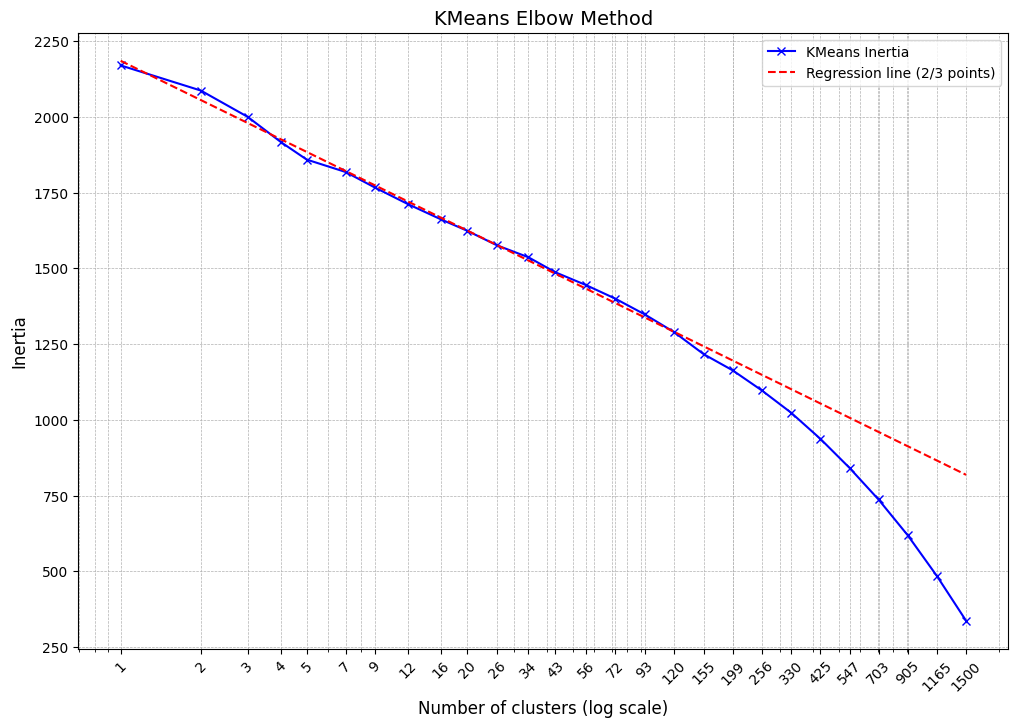

✅ Elbow method completed! Points tested: 27


In [ ]:
# @title Поиск оптимального k (глобальный диапазон)

i_values, distortions, reg_line = find_optimal_k_elbow(
    vectors,
    max_k=1500,
    num_points=30,
    random_state=42
)

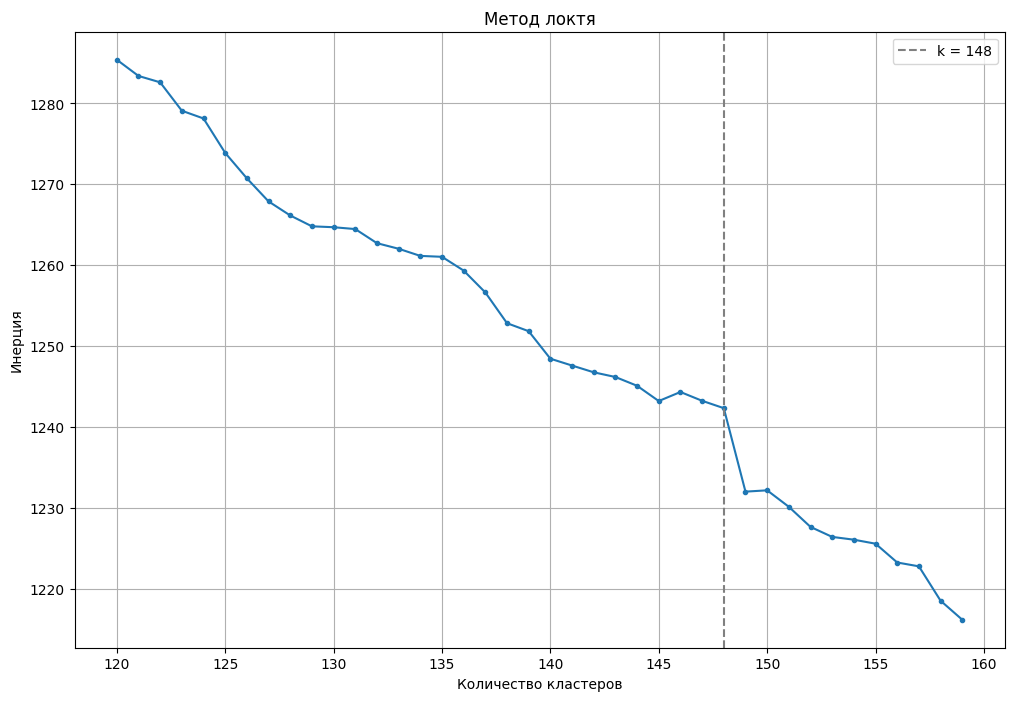

In [ ]:
# @title Детализируем локтевую область
cluster_range = range(120, 160)

distortions_local = elbow_method_range(
    vectors,
    cluster_range=cluster_range,
    show_vline=148
)

### Этап 2. Кластеризация по количеству кластеров 148

In [ ]:
# KMeans кластеризация
n_clusters = 148
clusters, centroids, kmeans_model = run_kmeans_clustering(vectors, n_clusters)

# t-SNE проекция
tsne_df, centroids_df = run_tsne_projection(vectors, clusters, unique_questions)

# t-SNE визуализация кластеров с центроидами и контурами
show_tsne_preview(tsne_df, centroids_df)

✅ KMeans: 148 кластеров построено.
✅ t-SNE готов!
✅ t-SNE чекпоинт: всего точек — 3056
📌 Всего кластеров в t-SNE: 148

🔍 Примеры точек t-SNE:


,TSNE1,TSNE2,Cluster,Message
0,-6.284027,-39.788876,38,Построй план обучения студента по курсу chatGP...
1,52.815281,-29.774427,59,что будет изучаться на программе нейронных сет...
2,-49.879303,49.877960,50,Что входит в тариф ПРдвинутый?
3,39.676010,35.226398,16,как проходят стажировки?
4,-10.391706,-56.006996,140,РАсскажи про продвинутый тариф chatGPT



📊 Топ-5 самых больших кластеров:


,Cluster,Count
38,38,79
16,16,66
24,24,66
30,30,57
57,57,56


### Этап 3. Визуализация

In [ ]:
# t-SNE визуализация кластеров с центроидами и контурами
plot_tsne_clusters(tsne_df, centroids_df)

In [ ]:
# @title Генерация заголовков с помощью GPT
messages = [
        {
            "role": "system",
            "content": (
                "Ты — методолог Университета Искусственного Интеллекта (УИИ). "
                "Твоя задача: прочитать список вопросов кластера и придумать краткое и ёмкое название для этого кластера "
                "(2-5 слов), отражающее основную тему вопросов"
                "Не добавляй лишних комментариев"
            )
        },
        {
            "role": "user",
            "content": (
                f"Вопросы кластера:  "
                "Сформулируй название кластера:"
            )
        }
    ]

cluster_titles = generate_all_cluster_titles(unique_questions, clusters, n_clusters)

✅ Кластер 0: Функции и возможности ботов
✅ Кластер 1: Сравнение курсов по ИИ
✅ Кластер 2: Тарифы и выгоды курсов
✅ Кластер 3: Курсы и программы по Data Science
✅ Кластер 4: Тарифы и их содержание
✅ Кластер 5: Обучение и курсы в УИИ
✅ Кластер 6: Учебный план курса ChatGPT Professional
✅ Кластер 7: История основания университета
✅ Кластер 8: Нейросети и автоматизация процессов
✅ Кластер 9: Обучение и курсы по ChatGPT
✅ Кластер 10: Гарантия трудоустройства
✅ Кластер 11: Ссылки на ресурсы и курсы
✅ Кластер 12: Возможности и условия обучения
✅ Кластер 13: Информация о компании и трудоустройстве
✅ Кластер 14: Обучение и тарифы моделей
✅ Кластер 15: Способности восприятия и понимания
✅ Кластер 16: Стажировки и практическое обучение
✅ Кластер 17: Тарифы на обучение
✅ Кластер 18: Помощь и полезность
✅ Кластер 19: Статистика студентов и выпускников
✅ Кластер 20: Информация о курсах и ценах
✅ Кластер 21: Развитие навыков в разработке
✅ Кластер 22: Навыки и Умения
✅ Кластер 23: Трудоустройство и э

In [ ]:
# @title Вывод списка вопросов по двум кластерам для визуализации
show_clustered_questions_with_titles(
    unique_questions,
    clusters,
    n_clusters,
    cluster_titles=cluster_titles,
    selected_clusters=[25, 93],
    max_questions=None  # Все вопросы
)

✅ Всего кластеров: 148
📌 Выведем кластеры: [25, 93]

🔹 Кластер ID: 25 | Название: Трудоустройство студентов | Всего вопросов: 28

   1. Расскажи о вопросах трудоустройства
   2. Как происходит трудоустройство
   3. Как происходит трудоустройство?
   4. Как быстро мы трудоустраиваем ?
   5. Как вы организуете трудоустройство?
   6. Как вы организуете трудоустройства студентов?
   7. Как мы помогаем с трудоустройствами студентам?
   8. Как вы организуете трудоустройство студентов?
   9. Как вы помогаете трудоустроиться студентам?
   10. Как вы трудоустраиваете студентов?
   11. Как вы поможете с трудоустройством?
   12. Что имеется в виду в трудоустройстве?
   13. Понял. А что за трудоустройство? Как вы его организуете?
   14. Как вы помогаете с трудоустройством?
   15. Найти работу
   16. А как это вы трудоустраиваете студентов?
   17. А как вы помогаете в трудоустройстве?
   18. А как вы трудоустраиваете?
   19. А как вы трудоустройства оказываете?
   20. какие условия должны быть выпо

In [ ]:
# @title Вывод списка вопросов по выборочному кластеру для визуализации
show_clustered_questions_with_titles(
    unique_questions,
    clusters,
    n_clusters,
    cluster_titles=cluster_titles,
    selected_clusters=[115],
    max_questions=7
)

✅ Всего кластеров: 148
📌 Выведем кластеры: [115]

🔹 Кластер ID: 115 | Название: Курсы по компьютерному зрению | Всего вопросов: 11

   1. Какова стоимость курса по CV?
   2. Какая цена курса по CV?
   3. Как приобрести курс по CV?
   4. Какой курс по CV я могу приобрести?
   5. Я хочу изучать CV. Какой курс мне необходимо купить?
   6. На этом курсе изучают CV?
   7. На этом курсе изучаются только основы CV?
   ... и ещё 4 вопросов
--------------------------------------------------


In [ ]:
# @title Вывод списка вопросов по двум выборочным кластерам для визуализации
show_clustered_questions_with_titles(
    unique_questions,
    clusters,
    n_clusters,
    cluster_titles=cluster_titles,
    selected_clusters=[11, 39],
    max_questions=7
)

✅ Всего кластеров: 148
📌 Выведем кластеры: [11, 39]

🔹 Кластер ID: 11 | Название: Ссылки на обучающие ресурсы | Всего вопросов: 21

   1. Ты умеешь скидывать необходимые ссылки с материалами университета, например презентации по стажировкам?
   2. На каком сайте?
   3. скинь ссылку на ваш вебинар по дообучению chaGPT
   4. киньте ссылку на оплату курса аи
   5. скинь мне ссылку на стажировку
   6. Чат по спортивной медицине дай ссылку, как с ним познакомиться?
   7. Жай ссылку вашего сайта
   ... и ещё 14 вопросов
--------------------------------------------------
🔹 Кластер ID: 39 | Название: Тарифные планы и предложения | Всего вопросов: 35

   1. Покажи мне таблицу сравнительную по вашим тарифам
   2. Расскажи про тарифы
   3. Какой тариф лучше выбрать для классификации документов?
   4. Какие курсы и тарифы сейчас есть?
   5. Какие у нас есть тарифы
   6. Напиши стоимость тарифов
   7. Напиши тарифы и что в них входит
   ... и ещё 28 вопросов
----------------------------------------

In [ ]:
# @title Вывод списка вопросов по выборочному кластеру для визуализации
show_clustered_questions_with_titles(
    unique_questions,
    clusters,
    n_clusters,
    cluster_titles=cluster_titles,
    selected_clusters=[7],
    max_questions=7 )

✅ Всего кластеров: 148
📌 Выведем кластеры: [7]

🔹 Кластер ID: 7 | Название: Основатели и история университета | Всего вопросов: 20

   1. Кто создатель университета
   2. университет сколько существует?
   3. Кто основатель университета
   4. Когда основан ваш университет
   5. Кто основатель университета?
   6. Кто основал ваш Университет? Долго работаете?
   7. Когда вы открылись? Кто основал Университет?
   ... и ещё 13 вопросов
--------------------------------------------------


### Этап 4. Наличие дубликатов и финальная очистка TF-IDF


In [ ]:
# @title Оставляем только уникальные вопросы
df_clusters, unique_questions_df = clean_clusters_tfidf_only(unique_questions, clusters, tfidf_threshold=0.7)

# Можно посмотреть на оставшиеся вопросы после чистки
unique_questions_df


### ✅ Всего вопросов до очистки: **3056**
### Найдено и удалено дубликатов: **695**
### Уникальных вопросов после TF-IDF: **2361**


,Вопрос,Кластер
0,Построй план обучения студента по курсу chatGP...,38
1,что будет изучаться на программе нейронных сет...,59
2,Что входит в тариф ПРдвинутый?,50
3,как проходят стажировки?,16
4,РАсскажи про продвинутый тариф chatGPT,140
...,...,...
2356,Какие возможности мы можем дать для графическо...,88
2357,Эти курсы платные,132
2358,После курса андроид приложение с нейронной сет...,42
2359,"Представь, что студент совсем ничего не знает....",47


## **Шаг 4. Строим гигачанки каждого кластера**

In [ ]:
# @title Этап 4.1 Загрузка и подготовка документа (база знаний УИИ), нарезка на чанки

# Запускаем обработку
source_chunks = process_text_file(os.path.join(root_path, text_file), len_chunk)
# Показываем первые 5 чанков
show_chunks_preview(source_chunks, start=0, end=3)

  0%|          | 0/1404 [00:00<?, ?it/s]

Обработка завершена!

✅ Всего чанков: 1404

🔹 Чанк #0 | 1,085 символов
------------------------------------------------------------
# Университет Искусственного Интеллекта
## Описание УИИ
Университет Искусственного Интеллекта - ведущее образовательное учреждение в России, специализирующееся исключительно на области искусственного интеллекта. Он является самым крупным университетом по ИИ в России и странах СНГ, признанным лидером в образовании в сфере ИИ. 
Параллельно с созданием курсов на протяжении пяти лет УИИ активно занимается разработкой в AI-сфере: создает AI-проекты для компаний на заказ.
УИИ не имеет филиалов за гран
------------------------------------------------------------


🔹 Чанк #1 | 677 символов
------------------------------------------------------------
## Язык обучения на курсах УИИ
Обучение на курсах УИИ проходит на русском языке.

## УИИ - резидент Сколково
ООО "Терра Эй Ай" - организационно-правовая форма УИИ. 
ООО "Терра Эй Ай" является резидентом Сколково.
Ссылк

In [ ]:
# @title Этап 4.2 Создаем базу FAISS из текстовой БЗ УИИ
db_faiss_main, count_tokens = create_faiss_index(source_chunks, embeddings, root_path, db_index_path, text_file, len_chunk, model_embed, pricing_per_million_tokens_usd,usd_price)

✅ Всего чанков: 1404
✅ Всего токенов (все чанки): 572,066
Индекс FAISS сохранён: /faiss_index/base_uii_edit_22_1024_large

Ориентировочная цена за embeddings: 6.29 руб.


In [ ]:
# @title Этап 4.3 Подбор 10 релевантных чанков к каждому вопросу на основе FAISS

clusters_context = build_clusters_context(db_faiss_main, unique_questions_df, k=10, cluster_titles=cluster_titles)

Кластер 0
Название кластера: Функции и возможности ботов
--------------------------------------------------
  Вопрос: Чем бот, отвечающий на вопросы об образовательных продуктах, полезен для компании? | Найдено документов: 10 | Средний score: 0.31
  Вопрос: Можно ли создать бота рассыльщика? | Найдено документов: 10 | Средний score: 0.30
  Вопрос: бот может разговаривать голосом? | Найдено документов: 10 | Средний score: 0.31
  Вопрос: я спрашиваю не про того, когда вы учите, а про вас - про бота. Вы только пишете? | Найдено документов: 10 | Средний score: 0.34
  Вопрос: Вы бот или человек? | Найдено документов: 10 | Средний score: 0.38
  Вопрос: может ли копайлот анализировать диалог в реальном времени? | Найдено документов: 10 | Средний score: 0.33
  Вопрос: Может ли отвечать голосом | Найдено документов: 10 | Средний score: 0.42
  Вопрос: Ты робот? | Найдено документов: 10 | Средний score: 0.36
  Вопрос: что умеет этот бот? | Найдено документов: 10 | Средний score: 0.30
  Вопрос: Че


✅ Фильтрация завершена:


,cluster,total_chunks,filtered_chunks,not_filtered_chunks,filtered_chunk_ids
0,0,74,14,60,"[1086, 1161, 827, 174, 845, 1087, 1059, 255, 9..."
1,1,72,12,60,"[255, 720, 565, 724, 1179, 603, 566, 87, 1271,..."
2,2,49,17,32,"[438, 1262, 1318, 1263, 1278, 1272, 1302, 1268..."
3,3,118,11,107,"[935, 264, 266, 246, 539, 252, 570, 1382, 938,..."
4,4,19,12,7,"[1318, 1272, 1302, 1268, 1297, 1357, 1294, 129..."


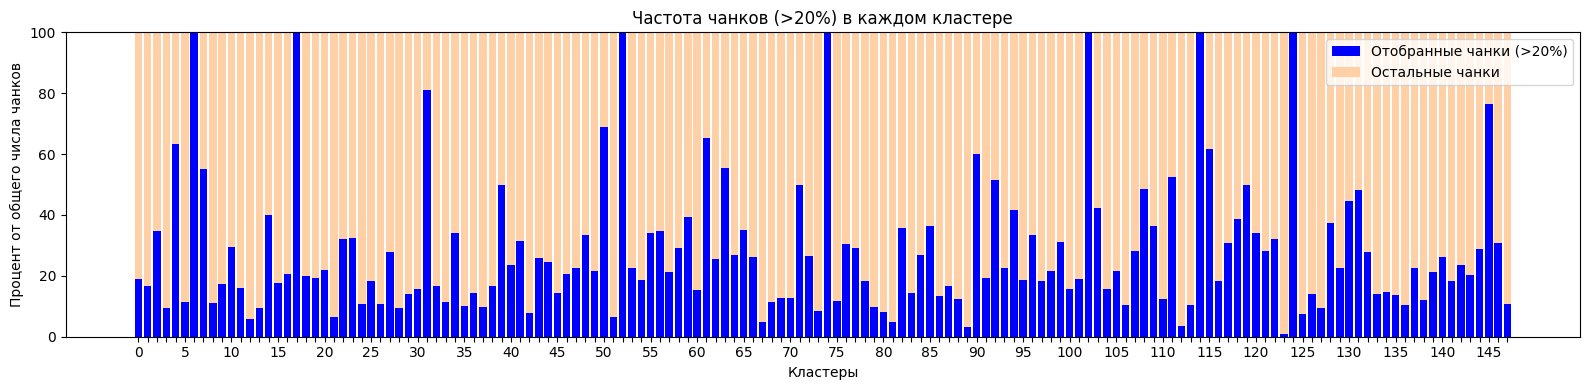

In [ ]:
# @title Этап 4.4 Фильтрация чанков всех вопросов кластера по частоте встречаемости при пороге 20%

filtered_df, united_chunks_clusters = filter_chunks_by_frequency(clusters_context, threshold=0.2)

In [ ]:
# @title Этап 4.5 Объединяем чанки в один связный гигачанк с помощью одного запроса к GPT

messages = [
        {"role": "system",
         "content": "Вы выдающийся методолог Базы Знаний компании Университета Искусственного Интеллекта(УИИ), "
                    "с познаниями в области искусственного"
                    "интеллекта и машинного обучения.\nВаша задача — объединить фрагменты из базы знаний в один документ. "
                    "Для этого необходимо их проанализировать, логически структурировать, убрать дубликаты. Ничего от себя не придумывай, используй только информацию из фрагментов базы знаний"},
        {"role": "user",
         "content": f"Пожалуйста объедините фрагменты из базы знаний в один документ.\n\nВАЖНО: не нужно придумывать то что не написано или отсутствует в "
                    f"фрагментах базы знаний).\n\nФрагменты базы знаний:\n\n{united_chunks_clusters}"}
    ]

df_united = pd.DataFrame(united_chunks_clusters)
df_united_final = process_chunks_parallel(df_united, max_threads=10)

# Показываем первые строки
df_united_final

,cluster,questions,unified_text,len_filtered_chunks,total_chunks,summary
0,0,"Чем бот, отвечающий на вопросы об образователь...","### Чат-бот умеет:\n1. отвечать на вопросы, св...",14,74,# Университет Искусственного Интеллекта\n\n## ...
1,1,Чем отличаются курсы Datasience от Chatgpt?\nр...,- Сапрыкин Дмитрий. Разработал собственные Cha...,12,72,# Университет Искусственного Интеллекта\n\n## ...
2,2,Какие знания я получу на продвинутом тарифе\nЕ...,## Стоимость прохождения программы на курсах У...,17,49,# Университет Искусственного Интеллекта\n\n## ...
3,3,что такое Data science\nКурс по PyTorch\nкурс ...,"## Профессия Data scientist\nПод профессией ""...",11,118,# Университет Искусственного Интеллекта\n\n## ...
4,4,Сколько стит тариф Прдвинутый?\nА что конкретн...,##### Тариф Pro\n - 5 занятий с кураторской...,12,19,# Университет Искусственного Интеллекта\n\n## ...
...,...,...,...,...,...,...
143,143,Ваш юридический адрес\nКак связаться\nкак вам ...,"ООО ""КОРАЛ ТРЕВЕЛ"" — лидер предоставления услу...",15,74,# Университет Искусственного Интеллекта\n\n## ...
144,144,Каковы критерии допуска студента к экзамену?\n...,## Экзамены УИИ:\nДля получения сертификата о ...,13,45,# Университет Искусственного Интеллекта\n\n## ...
145,145,сколько стоит консультация в тарифе лайт\nМожн...,"### Тарифы курса ""ChatGPT Professional New"":\n...",13,17,# Университет Искусственного Интеллекта\n\n## ...
146,146,сколько стоят зум консультации для PRO ПЛЮС\nр...,##### Тариф Pro\n - 5 занятий с кураторской...,13,42,# Университет Искусственного Интеллекта\n\n## ...


In [ ]:
# @title Google sheets с формированным гигачанком по выбранным кластерам (вопросы, отфильтрованные чанки и гигачанк)
df_report =  export_clusters_full_report(
    df_united_final=df_united_final,
    selected_clusters=[25, 71, 77, 82, 89, 93, 100, 106, 115, 119, 125, 130, 134, 138, 146],
    root_path=root_path,
    file_name="clusters_reports.xlsx",
    cluster_titles=cluster_titles
)

✅ Отчёт сохранён: /content/local_data/clusters_reports.xlsx
И на Google диск по ссылке 'https://docs.google.com/spreadsheets/d/18R5Fu9lt_bNBzDwBe0RPU6gn3m1q3n1TgKPSCCcJp7I/edit?usp=sharing


## **Шаг 5. Ответы на запросы клиента**

In [ ]:
# @title Этап 5.1 Создаем базу FAISS, где вектор - все вопросы кластера, а Гигачанк - метадата

db_united = create_faiss_index_united_clusters(
    df_united_final,
    embeddings,
    root_path,
    db_index_path,
    text_file,
    len_chunk,
    model_embed,
    pricing_per_million_tokens_usd,
    usd_price,
    history_cost
)

✅ Количество токенов в документе : 54,152

Индекс FAISS сохранён: /faiss_index/base_uii_edit_22_1024_summary_large

 ЦЕНА запроса создания базы индексов: 0.60 руб.


In [ ]:
# @title Этап 5.2.1 Пример нахождения релеватного кластера по новому вопросу

summary_text, cluster_id, best_score, cluster_title = find_relevant_cluster("Чем УИИ лучше конкурентов?", db_united, show_preview=True, cluster_titles=cluster_titles)


✅ Определён кластер: 92 | Название: Конкурентные преимущества университета (score: 0.27)

🔹 ВОПРОСЫ КЛАСТЕРА (первые 500 симв.):

Чем мы отличаемся от конкурентов
В чем ваше преимущество
У вашего университета есть конкуренты?
Кто выши конкуренты
Расскажи подробнее про анализ конкурентов
Кто ваши конкуренты?...

--------------------------------------------------

🔹 SUMMARY КЛАСТЕРА:

# Университет Искусственного Интеллекта  ## Чем УИИ лучше конкурентов  Университет Искусственного Интеллекта (УИИ)
предлагает ряд значительных преимуществ по сравнению с конкурентами в области образования по искусственному интеллекту
(AI):  1. **Собственная учебная платформа** стоимостью 10 млн. рублей, разработанная в течение 2 лет, обеспечивает
эффективную организацию прохождения курсов с отдельными блоками по каждой теме. Платформа включает 37 тем курсов,
дополнительные материалы, динамику по



In [ ]:
# @title Этап 5.2.1 Пример нахождения релеватного кластера по новому вопросу

summary_text, cluster_id, best_score, cluster_title = find_relevant_cluster("Что за курс по AutoML?", db_united, show_preview=True, cluster_titles=cluster_titles)


✅ Определён кластер: 71 | Название: Курс по AutoML и Генетическим Алгоритмам (score: 0.20)

🔹 ВОПРОСЫ КЛАСТЕРА (первые 500 симв.):

Расскажи про курс по AutoML
Генетические алгоритмы какие темы проходит. Примеры
Детальная программа курса  AutoML
Конкретный набор инструментов в курсе AutoML
расскажи для чайника, чему можно научиться на курсе по AutoML?
Что такое AutoML?
Нет ничего по AutoKeras, AutoML?
AutoML простыми словами
напиши пример использования AutoML...

--------------------------------------------------

🔹 SUMMARY КЛАСТЕРА:

# Университет Искусственного Интеллекта  ## Введение в AutoML и его преимущества AutoML - подход в искусственном
интеллекте, позволяющий обучать нейронные сети автоматически. Это считается передовой темой в сфере ИИ, и Университет
Искусственного Интеллекта (УИИ) выделяется на рынке, предлагая обучение и реальное применение AutoML в стажировках.
Стоит отказаться от традиционного подхода к написанию нейронных сетей в пользу AutoML, потому что он более эффе

In [ ]:
# @title Этап 5.2.2 Пример нахождения релеватного кластера по новому вопросу

summary_text, cluster_id, best_score, cluster_title = find_relevant_cluster("Как мне попасть на стажировку?", db_united, show_preview=True, cluster_titles=cluster_titles)


✅ Определён кластер: 16 | Название: Стажировки: Вопросы и Ответы (score: 0.27)

🔹 ВОПРОСЫ КЛАСТЕРА (первые 500 симв.):

как проходят стажировки?
Расскажи про стажировки?
Что такое дополнительные стажировки
сколько стоят 4 стажировки?
Как докупить стажировки за меньшую плату?
если деньги есть только на 1 стажировку, сделайте мне такое предложение.
Ккак проходят стажировки?
Как проходит практическая часть ?
Когда я смогу приступить к стажировкам?
Когда начинаются стажировки?
Возможно ли совмещать стажировку с работой?
У нас были стажировки по медицине?
Напиши список всех стажировок в сфере медицина
Каковы условия д...

--------------------------------------------------

🔹 SUMMARY КЛАСТЕРА:

# Университет Искусственного Интеллекта  ## Стажировки в УИИ  ### Общее описание программы стажировок Студенты,
проходящие курс в УИИ, имеют возможность участвовать в создании реальных проектов во время стажировок. В процессе
прохождения курса студенты проходят 4 стажировки в крупных компаниях, таких

In [ ]:
# @title Этап 5.2.4 Пример нахождения релеватного кластера по новому вопросу
summary_text, cluster_id, best_score, cluster_title=find_relevant_cluster("Как происходит трудоустройство?", db_united, show_preview=True, cluster_titles=cluster_titles)


✅ Определён кластер: 25 | Название: Трудоустройство студентов (score: 0.23)

🔹 ВОПРОСЫ КЛАСТЕРА (первые 500 симв.):

Расскажи о вопросах трудоустройства
Как происходит трудоустройство
Как быстро мы трудоустраиваем ?
Как вы организуете трудоустройство?
Как вы организуете трудоустройства студентов?
Как мы помогаем с трудоустройствами студентам?
Как вы помогаете трудоустроиться студентам?
Как вы трудоустраиваете студентов?
Как вы поможете с трудоустройством?
Что имеется в виду в трудоустройстве?
Как вы помогаете с трудоустройством?
А как вы помогаете в трудоустройстве?
А как вы трудоустройства оказываете?
какие у...

--------------------------------------------------

🔹 SUMMARY КЛАСТЕРА:

# Университет Искусственного Интеллекта  ## Описание гарантии трудоустройства Университет Искусственного Интеллекта
(УИИ) имеет собственное HR-агентство Al hunter и трудоустраивает выпускников в российские и зарубежные компании.
Официальная гарантия трудоустройства прописана в договоре. После прохождени

In [ ]:
# @title Этап 5.3 Формируем обращение к OpenAI
system = (
        "Ты - профессиональный менеджер Университета Искусственного Интеллекта (УИИ). Ответь на вопрос пользователя используя прилагаемые фрагменты документов.\n"
        "Отвечай кратко и по существу. Ответ не должен превышать 4000 символов.\n"
        "Тебе запрещено упоминать о предоставленных фрагментах документов.\n"
    )

user = (
        "Используй документ для формирования ответа пользователю.\n"
        "ВАЖНО: не нужно придумывать то что не написано или отсутствует в фрагментах базы знаний).\n"
        "Вопрос пользователя: {question}\n\n"
        "Фрагменты базы знаний:\n{chunks_text}\n\n"
    )

In [ ]:
# @title ОСНОВНОЙ ЦИКЛ ВОПРОСОВ
questions = [
    "Вы точно меня трудоустроите?",
    "Как получить доступ к библиотеке УИИ?",
    "Как выбрать тему AI проекта?",
    "Зачем мне Git?",
    "Мне 16. Смогу ли я у вас обучаться?"
]

for question in questions:
    print("\n" + "="*80)
    print(f"ВОПРОС: {question}")

    # Находим кластер
    summary_text, cluster_id, best_score, cluster_title = find_relevant_cluster(question, db_united, show_preview=False, cluster_titles=cluster_titles)

    print(f"НАЙДЕН КЛАСТЕР: {cluster_id} (score: {best_score:.2f})")
    print(f"НАЗВАНИЕ: {cluster_title}")

    # Генерируем ответ
    answer = answer_gpt(question, summary_text, model_answer)

    # Выводим финальный ответ
    print("\n" + "-"*80)


ВОПРОС: Вы точно меня трудоустроите?
НАЙДЕН КЛАСТЕР: 25 (score: 0.35)
НАЗВАНИЕ: Трудоустройство студентов

ИСПОЛЬЗОВАНА МОДЕЛЬ: gpt-4o-mini

ОТВЕТ GPT:
Да, Университет Искусственного Интеллекта (УИИ) предоставляет официальную гарантию трудоустройства для своих
выпускников. После завершения курса, сдачи экзамена и получения сертификата, УИИ обязуется помочь с трудоустройством,
включая консультации по вакансиям, рекомендации по резюме, подбор работодателей и сопровождение на собеседованиях. Более
60% студентов успешно находят работу, а остальные активно работают над своими резюме и проходят собеседования.

СТОИМОСТЬ ЗАПРОСА: {'prompt_tokens_cost': 0.0347, 'completion_tokens_cost': 0.007, 'total_cost': 0.0417}

--------------------------------------------------------------------------------

ВОПРОС: Как получить доступ к библиотеке УИИ?
НАЙДЕН КЛАСТЕР: 35 (score: 0.22)
НАЗВАНИЕ: Доступ и услуги УИИ

ИСПОЛЬЗОВАНА МОДЕЛЬ: gpt-4o-mini

ОТВЕТ GPT:
Чтобы получить доступ к библиотеке Университ